# FFNN
Laden des auf Hybrid_Datensatz trainierten Modells  
Test auf hybrid_b17_test (= 90% Benign IDS17 + 100% non-BENIGN IDS17)

In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import joblib
from sklearn.metrics import classification_report, confusion_matrix

2024-11-23 20:57:48.984957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-23 20:57:48.996010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 20:57:49.007399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 20:57:49.010675: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 20:57:49.021099: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='32_cnn_test.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [3]:
# Datensatz einlesen
df = pd.read_parquet(hybrid_test_prep_1)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-23 20:57:50 - INFO - Class distribution
Label
DoS Hulk                        1803160
BENIGN                          1424304
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Name: count, dtype: int64


(3874334, 51)
Index(['Total TCP Flow Time', 'Fwd IAT Total', 'Fwd Header Length', 'Idle Std',
       'Bwd Header Length', 'Dst Port', 'ECE Flag Count', 'Fwd IAT Max',
       'Fwd Packet Length Max', 'Fwd PSH Flags', 'Fwd Bulk Rate Avg',
       'Protocol', 'Bwd Packet Length Min', 'Bwd Init Win Bytes',
       'Flow Bytes/s', 'Fwd IAT Mean', 'FWD Init Win Bytes',
       'Fwd Packet Length Min', 'Total Length of Fwd Packet', 'Bwd IAT Std',
       'Bwd IAT Min', 'Bwd Bulk Rate Avg', 'Bwd Bytes/Bulk Avg',
       'Bwd Packet Length Std', 'Bwd URG Flags', 'Flow IAT Mean',
       'Fwd IAT Min', 'Subflow Bwd Packets', 'Fwd Seg Size Min',
       'Fwd RST Flags', 'Bwd PSH Flags', 'Flow IAT Max', 'FIN Flag Count',
       'SYN Flag Count', 'Bwd IAT Total', 'Bwd Segment Size Avg',
       'Down/Up Ratio', 'Total Fwd Packet', 'Packet Length Variance',
       'Fwd URG Flags', 'Flow IAT Min', 'Active Min', 'Bwd IAT Mean',
       'Bwd Packets/s', 'Bwd RST Flags', 'RST Flag Count', 'Active Std',
       'S

### Trennen von Features und Labels

In [4]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (3874334, 50)
Form von y: (3874334,)


### Label Encoding für y

In [5]:
label_encoder = joblib.load('label_encoder.pkl')
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Skallierung von X

In [6]:
scaler = joblib.load('scaler.pkl')
X_scaled = scaler.transform(X)

print("Form von X:", X.shape)
print("Form von X_scaled:", X_scaled.shape)

Form von X: (3874334, 50)
Form von X_scaled: (3874334, 50)


### Überprüfen der Klassenverteilung

In [7]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_encoded, "Testdatensatz")

Klassenverteilung in Testdatensatz:
  Klasse 0: 1424304 Beispiele (36.76%)
  Klasse 1: 142921 Beispiele (3.69%)
  Klasse 2: 289328 Beispiele (7.47%)
  Klasse 3: 22560 Beispiele (0.58%)
  Klasse 4: 1803160 Beispiele (46.54%)
  Klasse 5: 8490 Beispiele (0.22%)
  Klasse 6: 89374 Beispiele (2.31%)
  Klasse 7: 94197 Beispiele (2.43%)



### Laden des Modells

In [8]:
model = keras.models.load_model('model.keras')

I0000 00:00:1732391871.767370 1333897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732391871.790757 1333897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732391871.790795 1333897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732391871.792594 1333897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732391871.792623 1333897 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

### Evaluierung des Modells auf dem Testdatensatz - Klassifikationsbericht und eine Konfusionsmatrix

In [9]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_scaled)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_encoded, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_encoded, y_pred_classes)

I0000 00:00:1732391875.131596 1334079 service.cc:146] XLA service 0x7fdb70004900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732391875.131623 1334079 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-23 20:57:55.135374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-23 20:57:55.156354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   225/121073 ━━━━━━━━━━━━━━━━━━━━ 1:21 675us/step

I0000 00:00:1732391875.403393 1334079 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


121073/121073 ━━━━━━━━━━━━━━━━━━━━ 88s 726us/step
                              precision    recall  f1-score   support

                      BENIGN       0.40      1.00      0.57   1424304
                 Botnet Ares       1.00      1.00      1.00    142921
              DDoS-LOIC-HTTP       0.00      0.00      0.00    289328
               DoS GoldenEye       0.98      0.83      0.90     22560
                    DoS Hulk       0.00      0.00      0.00   1803160
               DoS Slowloris       0.86      0.91      0.88      8490
Infiltration - NMAP Portscan       0.97      0.79      0.87     89374
              SSH-BruteForce       1.00      1.00      1.00     94197

                    accuracy                           0.45   3874334
                   macro avg       0.65      0.69      0.65   3874334
                weighted avg       0.24      0.45      0.30   3874334



Visualisierung der Konfusionsmatrix

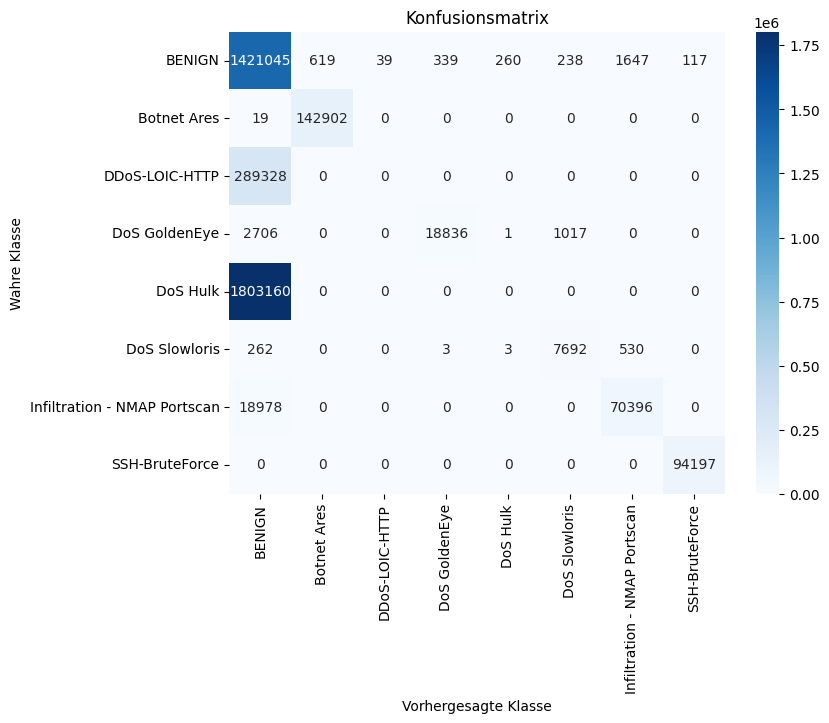

In [10]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()
